## Import modules

In [1]:
import os 
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

## Extract Image Features

In [2]:
# load vgg16 model
model = VGG16()

# restructure the model
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

# print(model.summary())

In [3]:
# extract features from images
features = {}
directory = ('Images')

for img_name in tqdm(os.listdir(directory)):
    # load image
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224,224))

    # convert image pixels to numpy array
    image = img_to_array(image)

    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # preprocess image for vgg
    image = preprocess_input(image)

    #extract features
    feature = model.predict(image, verbose = 0)

    # get image ID
    image_id = img_name.split('.')[0]

    #store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [4]:
print(features[image_id])

[[0.        0.        0.9586383 ... 0.        0.        0.       ]]


In [5]:
# store features in pickle
pickle.dump(features, open('features.pkl', 'wb'))

In [2]:
# load features from pickle
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

## Load the captions data

In [3]:
with open('captions.txt', 'r') as f:
    next(f)
    captions_doc = f.read()

In [4]:
# create mapping of image to captions
mapping = {}

# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    
    image_id, caption = tokens[0], tokens[1:]

    # remove extensions from image id
    image_id = image_id.split('.')[0]

    # convert caption list to string
    caption = " ".join(caption)

    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [5]:
len(mapping)

8091

In [6]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]

            # preprocessing 
            caption = caption.lower()
            caption = caption.replace('[^a-zA-Z]', '')
            caption = caption.replace('\s+', ' ')

            # add start and end tags to the caption
            # caption = '<start> ' + caption + ' <end>'
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'

            captions[i] = caption

In [7]:
# before processing of text
mapping[image_id]

['A man in a pink shirt climbs a rock face',
 'A man is rock climbing high in the air .',
 'A person in a red shirt climbing up a rock face covered in assist handles .',
 'A rock climber in a red shirt .',
 'A rock climber practices on a rock climbing wall .']

In [8]:
# preprocessing of data
clean(mapping)

In [9]:
# after processing the data
mapping[image_id]

['startseq man in pink shirt climbs rock face endseq',
 'startseq man is rock climbing high in the air endseq',
 'startseq person in red shirt climbing up rock face covered in assist handles endseq',
 'startseq rock climber in red shirt endseq',
 'startseq rock climber practices on rock climbing wall endseq']

In [10]:
all_captions = []
for key in mapping:
    for captions in mapping[key]:
        all_captions.append(captions)

In [11]:
print(len(all_captions))

40455


In [12]:
print(all_captions[:10])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri-colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


In [13]:
# tokenise the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [14]:
vocab_size

8485

In [15]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test split

In [16]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.9)

train = image_ids[:split]
test = image_ids[split:]

In [21]:
# create data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_length, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n+=1
            captions = mapping[key]

            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]

                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]  

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer='adam')

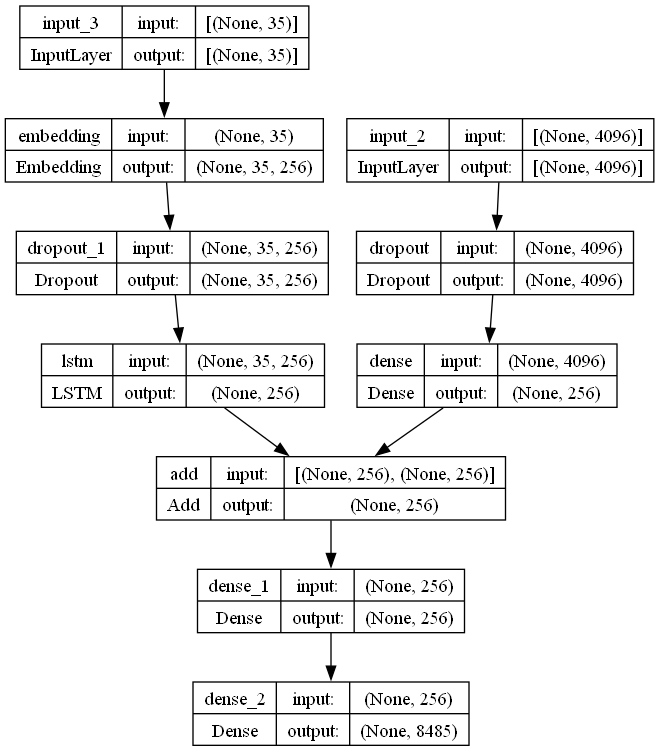

In [23]:
# plot the model
plot_model(model, show_shapes=True)

In [24]:
# train the model 
epochs = 30
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 413s 4s/step - loss: 2.0662


In [25]:
# save the model
model.save('best_model.h5')

c:\Users\Subash\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Generaate captions for the Image

In [17]:
from tensorflow.keras.models import load_model

# loading the model
model = load_model('best_model.h5')

In [18]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word

    return None

In [19]:
# generate caption for an image
def predict_caption(model, image, tokenizer, ax_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate of the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with highest probability
        yhat = np.argmax(yhat)
        # convert index into word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [29]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict new caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_caption = [caption.split() for caption in captions]
    actual.append(actual_caption)
    y_pred = y_pred.split()
    predicted.append(y_pred)

  0%|          | 0/810 [00:00<?, ?it/s]

In [30]:
from nltk.translate.bleu_score import corpus_bleu

# calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights = (1, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights = (0.5, 0.5, 0, 0)))

BLEU-1: 0.537908
BLEU-2: 0.316005


## Vizualize the results

In [30]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    image = Image.open("Images/"+image_name)
    captions = mapping[image_id]
    print('-----------------Actual-----------------')
    for caption in captions:
        print(" ".join(caption.split()[1:-1]))
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('-----------------Predicted-----------------')
    print(" ".join(y_pred.split()[1:-1]))
    plt.imshow(image)

-----------------Actual-----------------
baby girl in an orange dress gets wet as she stands next to water sprinkler
blonde toddler wearing an orange dress is wet and standing beside sprinkler in yard
child in dress is looking at sprinkler
little girl in an orange dress is running through the sprinkler in the yard
"on wet grass little blond girl in orange dress plays in sprinkler ."
-----------------Predicted-----------------
little girl in orange dress is playing with sprinkler


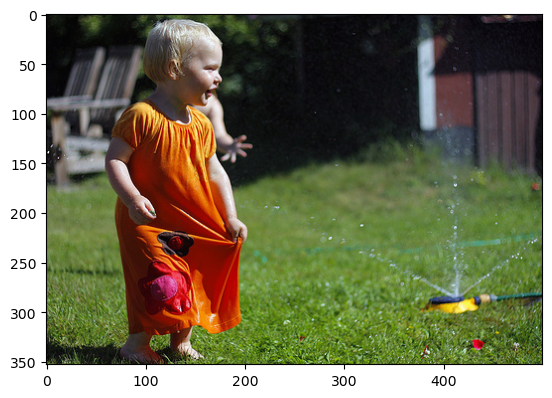

In [31]:
generate_caption("3767841911_6678052eb6.jpg")

-----------------Actual-----------------
hiker ascends snowy hill
man reaches the top of tall sand dune
person is hiking to the top of hill
person walks up white sandy hill against the blue sky
the person is wearing shorts and climbing gray sand hill under blue sky
-----------------Predicted-----------------
hiker ascends snowy hill


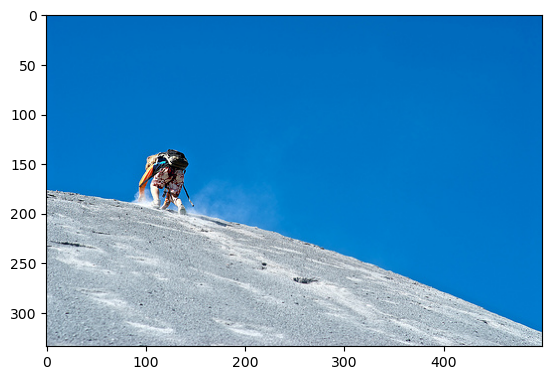

In [32]:
generate_caption("3745451546_fc8ec70cbd.jpg")

-----------------Actual-----------------
boy and his bike leaps into the air
boy does tricks on bicycle while in park
boy doing trick on bike
boy is doing tricks on his bike as he flies in the air
this young biker has his arms out as he tries this trick
-----------------Predicted-----------------
boy is doing trick on his bike


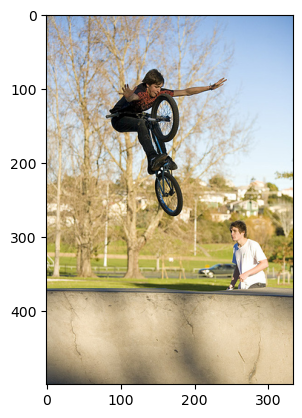

In [33]:
generate_caption("3722507770_0d6cb7420e.jpg")